In [1]:
%matplotlib notebook

In [2]:
import pyspark
sc = pyspark.sql.SparkSession.Builder().getOrCreate()

In [3]:
import json
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pyspark.sql.functions as F

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [4]:
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [5]:
FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]

## Entreno el modelo que vamos a usar para predecir

In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [8]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

## Levanto el archivo con las emisiones de los pajaros

In [63]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

### Me quedo solo con pajaros etiquetados

In [64]:
birds_recep = birds_recep.filter(lambda x: x['tag_id'] in MALES+FEMALES)

### Filtro a partir de las fechas obtenida

In [65]:
start_date = '2018-01-10'
end_date = '2018-01-26'
birds_recep = birds_recep.filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date)

In [66]:
birds_recep.count()

1069514

### Filtro en solo los horarios que nos interesa analizar y hago un checkpoint en disco

In [67]:
START_TIME = '00:00:00'
END_TIME = '09:00:00'
birds_data_complete_df = birds_recep.filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME).toDF()
birds_data_complete_df.write.parquet('tmp/checkpoint-sd.parquet')


### Levanto el chekpoint en pandas

In [9]:
birds_data_complete = pd.read_parquet('tmp/checkpoint-sd.parquet')
birds_data = birds_data_complete.drop(columns=['tag_id','timestamp'])

### Obtengo las predicciones

In [10]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(birds_data_complete)], axis=1).values

In [11]:
predictions_pd = pd.DataFrame(predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time'])
predictions_pd.head()

x        y recep_0 recep_1 recep_2 recep_3 tag                 time
0  2131.74  1623.71      44      50       0       0  24  2018-01-10 00:00:00
1  1961.74  1696.24      53      53       0       0  20  2018-01-10 00:00:00
2  1896.74  1308.14       0      47       0       0  27  2018-01-10 00:00:02
3  2528.65  1848.32      37       0       0      94  33  2018-01-10 00:00:02
4  2064.41  1339.77       0      30       0       0  32  2018-01-10 00:00:03

In [19]:
predictions_pd['day'] = predictions_pd['time'].str.split(' ').str[0]
predictions_pd['hour'] = predictions_pd['time'].str.split(' ').str[1].str.split(':').str[0].astype(int)

In [59]:
time_in_roost_per_day = predictions_pd[
    (predictions_pd['hour'] <= 3) &
    (~predictions_pd['tag'].isin([15,16]))
].groupby(['day', 'tag']).agg({'in_roost': ['mean', 'sum','count']})
time_in_roost_per_day.head()

in_roost           
                    mean  sum count
day        tag                     
2018-01-10 20   0.046091   56  1215
           21   0.147624  146   989
           22   0.000000    0    82
           24   0.000000    0  2824
           27   0.000000    0  2779

In [60]:
def plot_colormap(piv, cmap, title, xlabel, ylabel, clim=None):
    """
    Generate a color map plot
    
    Args:
        piv: pivot table
        cmap: str of color name
        title: str of grafic title
        xlabel: str of x label
        ylabel: str of y label
    """
    
    fig, ax = plt.subplots()
    im = ax.imshow(piv, cmap=cmap)
    fig.colorbar(im, ax=ax)
    # set min, max values
    if clim is not None:
        im.set_clim(clim)
    ax.set_xticks(range(len(piv.columns)))
    ax.set_yticks(range(len(piv.index)))
    ax.set_xticklabels(piv.columns, rotation=90)
    ax.set_yticklabels(piv.index)
    ax.set_title(**title)
    ax.set_xlabel(**xlabel)
    ax.set_ylabel(**ylabel)
    plt.savefig('emissions_distribution.png')
    plt.tight_layout()
    plt.show()
    

### Porcentaje de las emisiones que caen dentro del dormidero

<IPython.core.display.Javascript object>


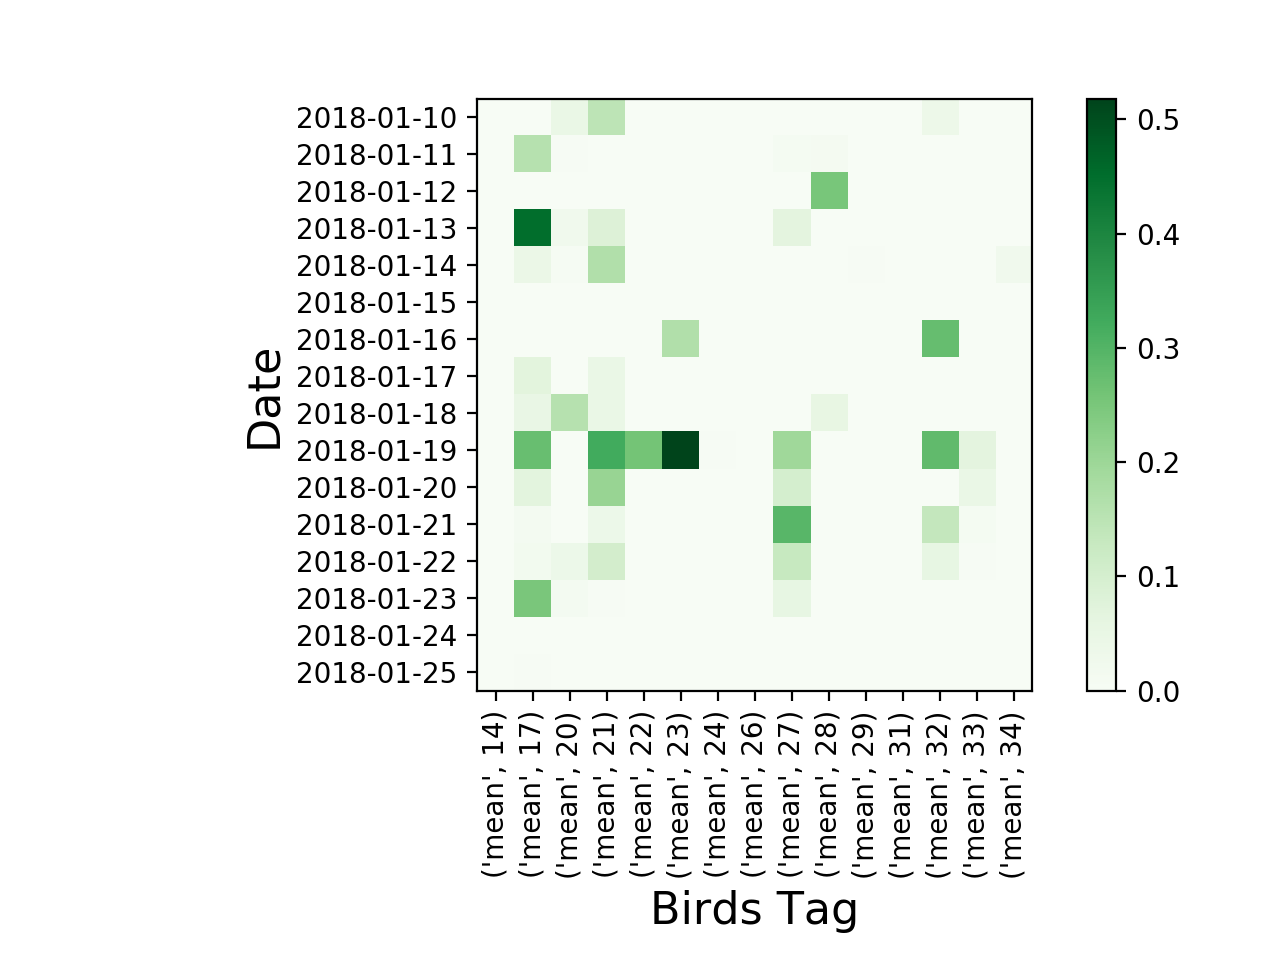

In [61]:
plot_args = {
    'cmap': 'Greens',
    'title': {'label': ' ', 'fontsize': 24},
    'xlabel': {'xlabel': 'Birds Tag', 'fontsize': 16},
    'ylabel': {'ylabel': 'Date', 'fontsize': 16}
}
dataset_piv = time_in_roost_per_day.xs('in_roost', axis=1)[['mean']].unstack(level=-1).fillna(0)
plot_colormap(
    dataset_piv,
    **plot_args
)

### Total de emisiones

<IPython.core.display.Javascript object>


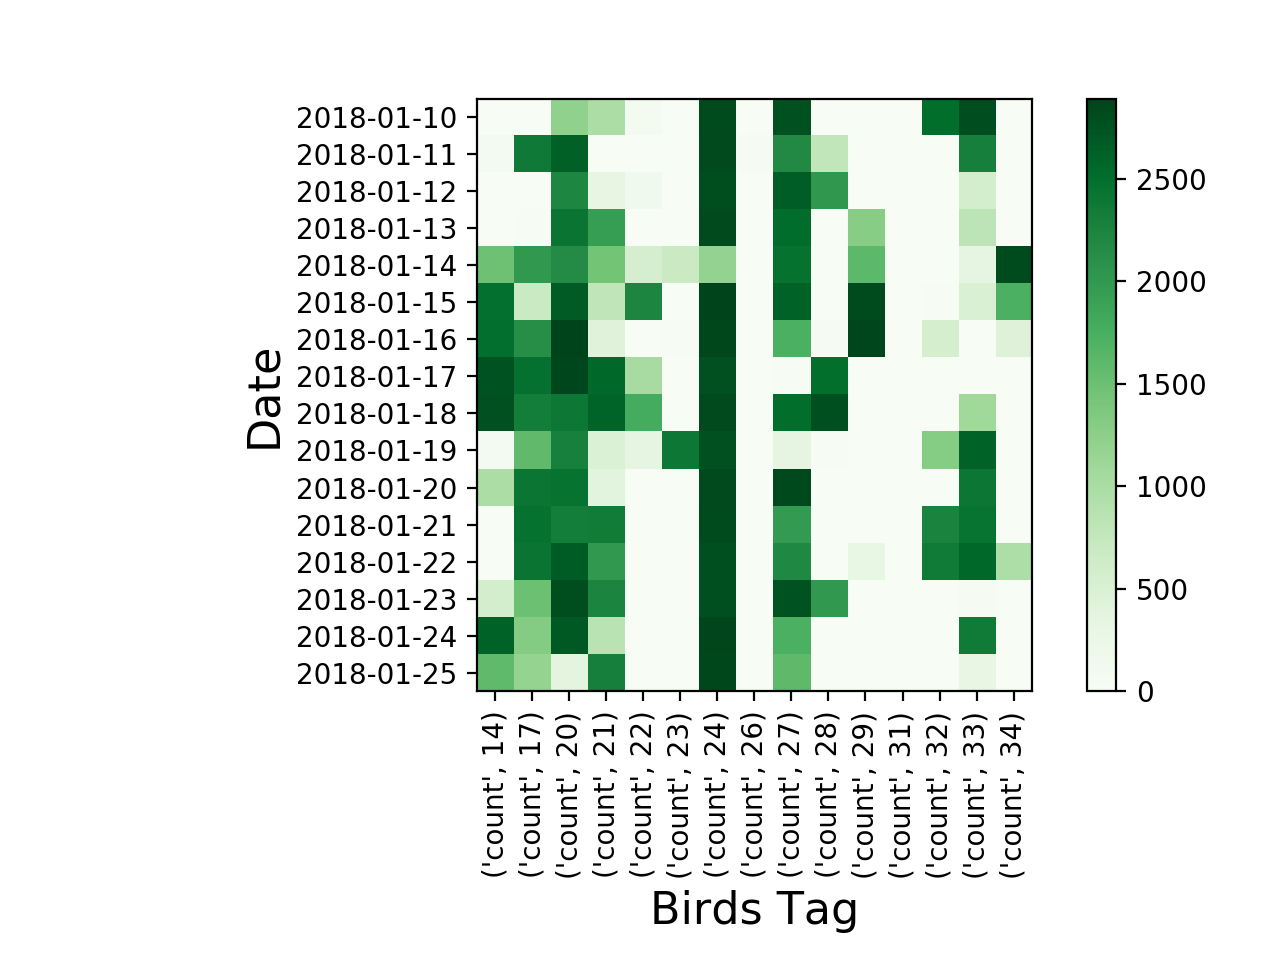

In [62]:
dataset_piv = time_in_roost_per_day.xs('in_roost', axis=1)[['count']].unstack(level=-1).fillna(0)
plot_colormap(
    dataset_piv,
    **plot_args
)

### Calculo si la prediccion cayó fuera del dormidero

In [16]:
def set_prediction_in_roost(predictions):
    roost_predictions = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        point = Point(prediction[0], prediction[1])
        if DORMIDERO.contains(point):
            roost_pred = np.insert(prediction, 8, 1, axis=0)
        else:
            roost_pred = np.insert(prediction, 8, 0, axis=0)
        roost_predictions.append(roost_pred)
    return pd.DataFrame(roost_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'in_roost'])


### Obtengo el tiempo en que cada posible pareja esta junta

In [14]:
def get_bird_timestamp_in_grid(bird_data, delta_time_in_sec):
    """
    delta_time_in_sec es la cantidad de segundos que decimos que el pajaro se encuentra en un mismo punto dada una prediccion
    Por default, el valor es 5, ya que las emisiones son cada 5 segundos.
    """
    timestamp_in_grid = []
    for row in bird_data['time']:
        real_time = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
        for i in range(-delta_time_in_sec, delta_time_in_sec+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append(datetime.strftime(res, '%Y-%m-%d %H:%M:%S'))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['time'])


def get_grid_matches_per_bird(grid_predictions, delta_time):
    male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions['region'] == 'in_grid')]

    matches_per_bird = {}
    for female_bird in FEMALES:
        female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions['region'] == 'in_grid')]
        timestamp_in_grid_pd = get_bird_timestamp_in_grid(female_bird_in_grid, delta_time)

        male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index('time'), on='time', how='inner')

        female_matches = {}
        for index, row in male_in_grid_with_female.iterrows():
            tag = row['tag']
            current_matches = female_matches.get(tag, 0)
            female_matches[tag] = current_matches+1

        matches_per_bird[female_bird] = female_matches
    return matches_per_bird



### Imprimo matriz de confusion

In [37]:
def show_confusion_matrices(matches_per_female):
    matrix_res = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        matrix_res[i] = []
        for m in MALES:
            matrix_res[i].append(matches_per_female.get(FEMALES[i]).get(m, 0))
         
    plt.figure(figsize=(10,15))
    
    plt.subplot(3, 1, 1)
    plt.title('Birds matches')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    yield matrix_res_pd
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
    ax.set(xlabel='Males', ylabel='Females')



    ### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
    ### con cualquier hembra estuvieron juntos
    plt.subplot(3, 1, 2)
    plt.title('Male time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')


    ### Igual, pero con las hembras
    plt.subplot(3, 1, 3)
    plt.title('Female time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0, vmax=100)
    ax.set(xlabel='Males', ylabel='Females')



In [16]:
def evaluate_grid_coocurrence(predictions, delta_time=5):
    predictions = set_prediction_grid_classification(predictions)
    matches_per_bird = get_grid_matches_per_bird(predictions, delta_time)
    show_confusion_matrices(matches_per_bird)

### Estimo el dormidero

In [15]:
## punto 344
limit_0 = normalizer._normalize_positions({'x': 465188.488248000, 'y':6111320.663286370})

## punto 341
limit_1 = normalizer._normalize_positions({'x': 464932.467224247, 'y':6111165.302211680})

## punto 104
limit_2 = normalizer._normalize_positions({'x': 463817.039780386, 'y':6111656.427363250})

## punto 11
limit_3 = normalizer._normalize_positions({'x': 463524.533058300, 'y':6111946.149998700})

limits = [limit_0, limit_1, limit_2, limit_3]

<IPython.core.display.Javascript object>


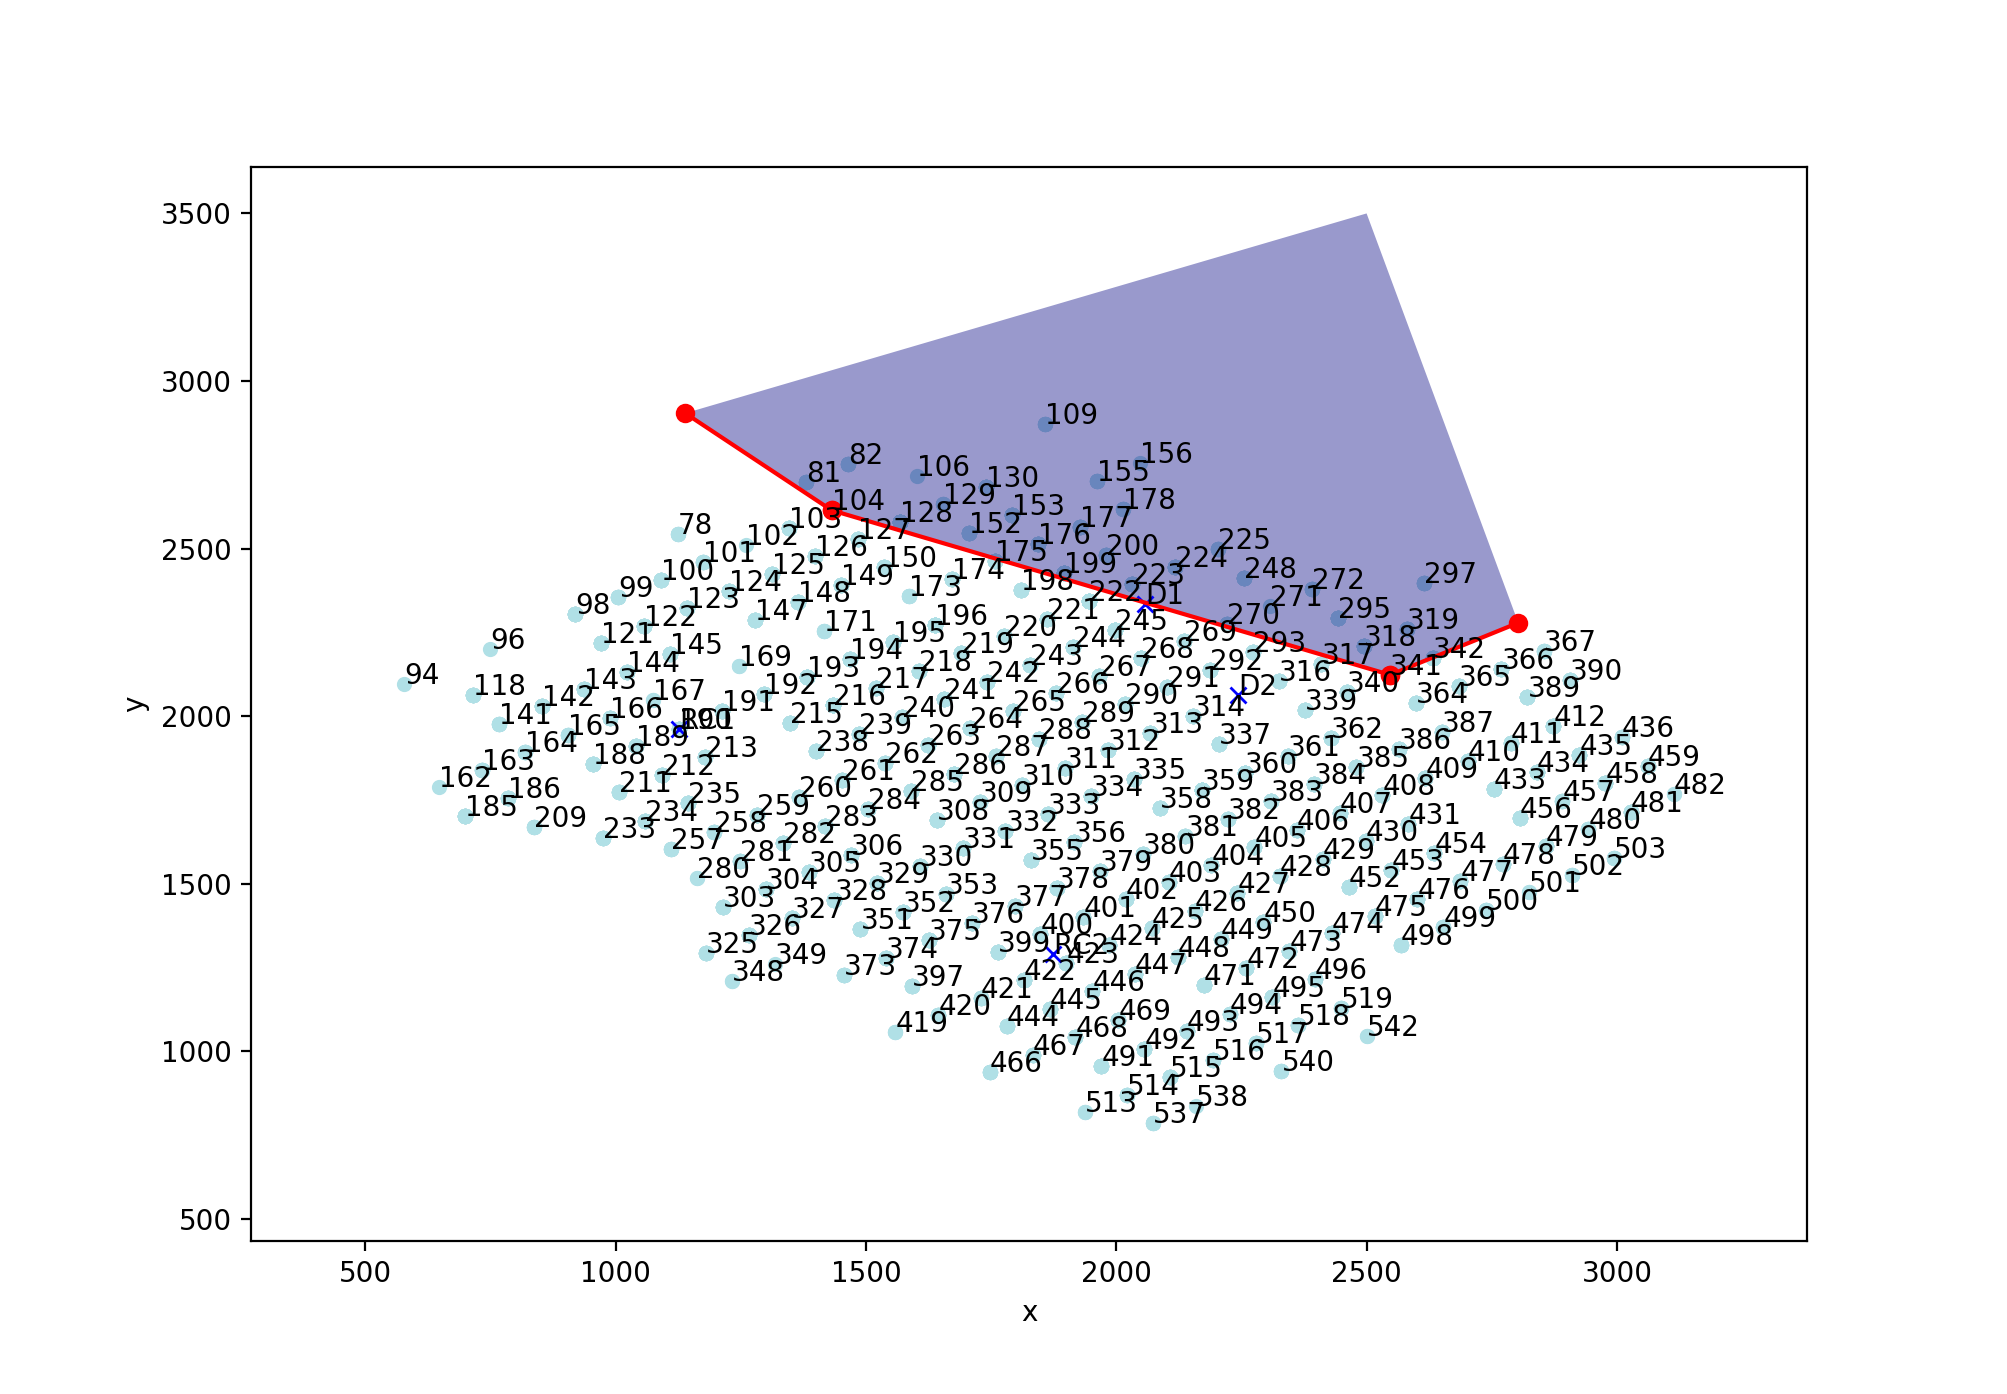

(0, 3572.611122813949)

In [52]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import PatchCollection

patches = []
polygon = matplotlib.patches.Polygon(limits_positions, True)
patches.append(polygon)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
colors = 100*np.random.rand(1)
p.set_array(np.array(colors))



x_f = 465958.114906211
y_f = 6112715.80637111
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 

#points_sig = points_recep.groupBy(lambda x:x['Punto']).map(calculate_amount_antennas_recep).map(normalize_positions)
ax = pd.DataFrame(data.map(lambda x: {'x': x['x'], 'y':x['y']}).collect()).plot.scatter(x='x', y='y', c='#B0E0E6')

for i in range(4):
    pos_antena = posicion_antenas[i]
    ax.plot(pos_antena[0]-X_0, pos_antena[1]-Y_0, "xb")
    ax.text(pos_antena[0]-X_0, pos_antena[1]-Y_0, nombre_antenas[i])

'''
x,y = GRID.exterior.xy
ax.plot(x, y, color='orange', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
'''
for point in data.groupBy(lambda x: x['point']).map(lambda x: list(x[1])[0]).collect():
    ax.text(point['x'], point['y'], point['point'])

#plt.plot((1928.32066337199656, 2546.9634408499696), (2565.1405697204173, 2122.9506730306894), 'ro-')
#plt.plot((1928.32066337199656, 1397.9205800319905), (2565.1405697204173, 2476.9784118300304), 'ro-')

plt.plot((limit_0['x'], limit_1['x']), (limit_0['y'], limit_1['y']), 'ro-')
plt.plot((limit_1['x'], limit_2['x']), (limit_1['y'], limit_2['y']), 'ro-')
plt.plot((limit_2['x'], limit_3['x']), (limit_2['y'], limit_3['y']), 'ro-')
#plt.plot((limit_3['x'], limit_4['x']), (limit_3['y'], limit_4['y']), 'ro-')

ax.add_collection(p)


plt.ylim(0,y_f-Y_0)
plt.xlim(0,x_f-X_0)

In [16]:
limits_positions = []
for limit in limits:
    limits_positions.append((limit['x'], limit['y']))
limits_positions.append((2500,3500))
DORMIDERO = Polygon(limits_positions)

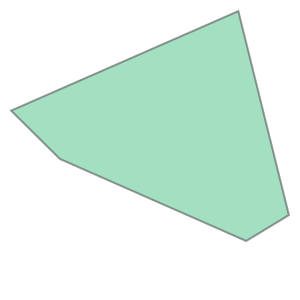

In [61]:
DORMIDERO

### Veo salida del dormidero usando los momentos donde mas cambia las señales recibidas

In [12]:
predictions_pd.head()

x        y recep_0 recep_1 recep_2 recep_3 tag                 time
0  2131.74  1623.71      44      50       0       0  24  2018-01-10 00:00:00
1  1961.74  1696.24      53      53       0       0  20  2018-01-10 00:00:00
2  1896.74  1308.14       0      47       0       0  27  2018-01-10 00:00:02
3  2528.65  1848.32      37       0       0      94  33  2018-01-10 00:00:02
4  2064.41  1339.77       0      30       0       0  32  2018-01-10 00:00:03

In [13]:
for i in range(4):
    col = 'recep_{}'.format(i)
    predictions_pd[col] = predictions_pd[col].astype(int)

In [17]:
predictions_pd['day'] = predictions_pd['time'].str.split(' ').str[0]
predictions_pd['hour'] = predictions_pd['time'].str.split(' ').str[1].str.split(':').str[0].astype(int)

In [18]:
from datetime import datetime

def get_seq_time(row):
    return (datetime.strptime(row['time'], '%Y-%m-%d %H:%M:%S')-datetime.strptime(row['day'], '%Y-%m-%d')).total_seconds()

predictions_pd['seq_time'] = predictions_pd.apply(get_seq_time, axis=1)

In [20]:
def get_hour_from_seq_time(seq_time):
    seconds = seq_time%60
    seq_time = (seq_time-seconds)/60
    minutes = seq_time%60
    seq_time = (seq_time-minutes)/60
    hour = seq_time
    return '{}:{}:{}'.format(
        str(int(hour)).rjust(2, '0'), 
        str(int(minutes)).rjust(2, '0'), 
        str(int(seconds)).rjust(2, '0')
    )

In [219]:
### bad examples
# '2018-01-24' - 30
# '2018-01-11' - 20
# '2018-01-25' - 20

<IPython.core.display.Javascript object>


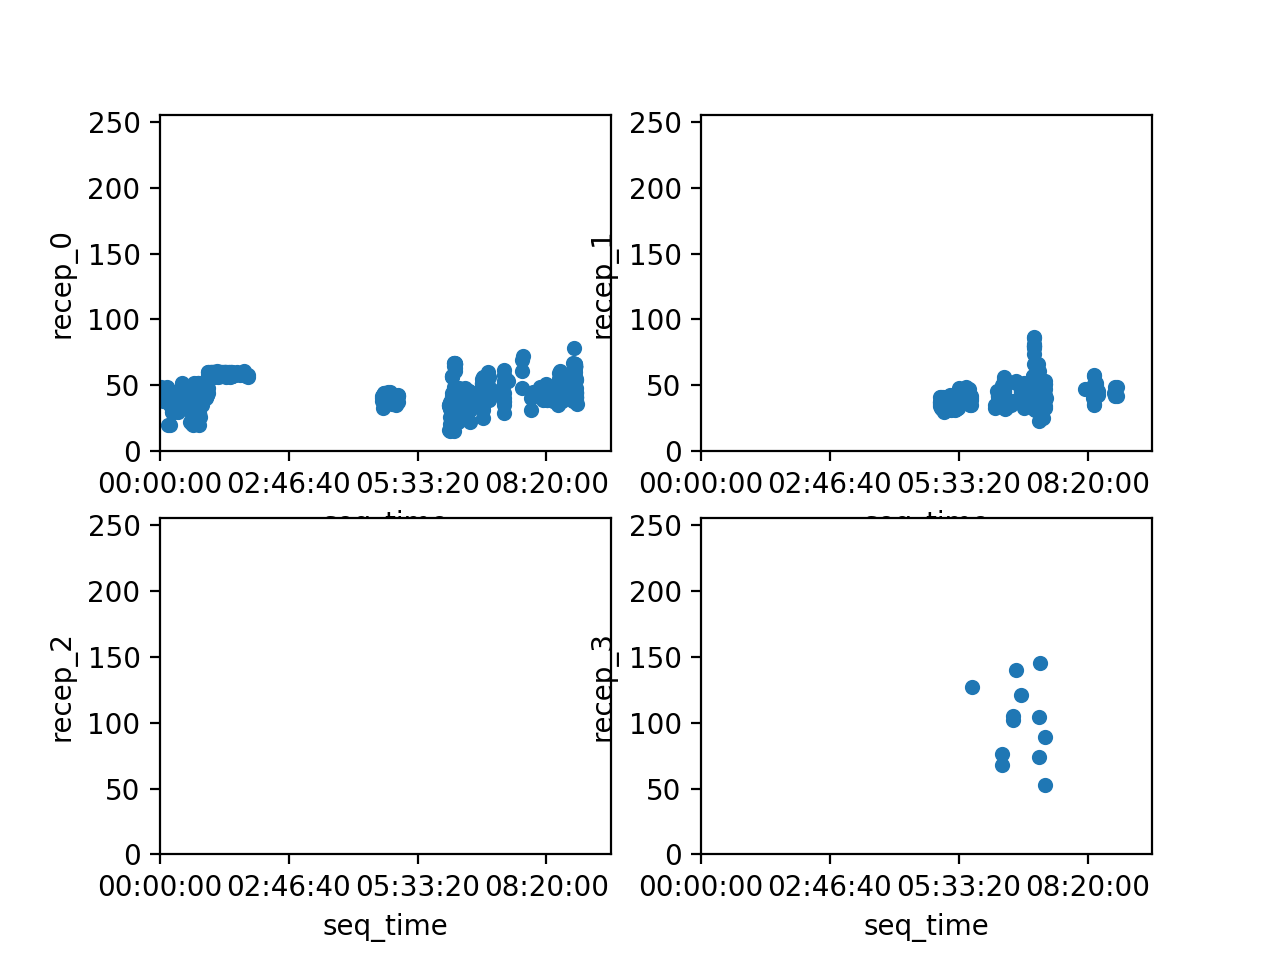

In [221]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2)


DAY = '2018-01-25'
BIRD = 20

for i in range(2):
    for j in range(2):
        data = predictions_pd.query('day == "{}" and tag == {}'.format(DAY, BIRD))
        data = data.query('recep_{} > 0'.format(i*2+j))
        if len(data) == 0:
            data = pd.DataFrame({'seq_time': [-1000], 'recep_{}'.format(i*2+j): 0})
        data.plot(kind='scatter', x='seq_time', y='recep_{}'.format(i*2+j), xlim=(0,35000), ylim=(0,255), ax=axes[i,j])
        axes[i,j].set_xticklabels([get_hour_from_seq_time(tick) for tick in axes[i,j].get_xticks().astype(int)])


### Prueba tsne

In [77]:
from sklearn.manifold import TSNE

In [80]:
prueba = predictions_pd.query('day == "2018-01-16"').copy()

In [83]:
prueba['tsne'] = TSNE(n_components=1).fit_transform(prueba[['recep_0', 'recep_1', 'recep_2', 'recep_3']])

<IPython.core.display.Javascript object>


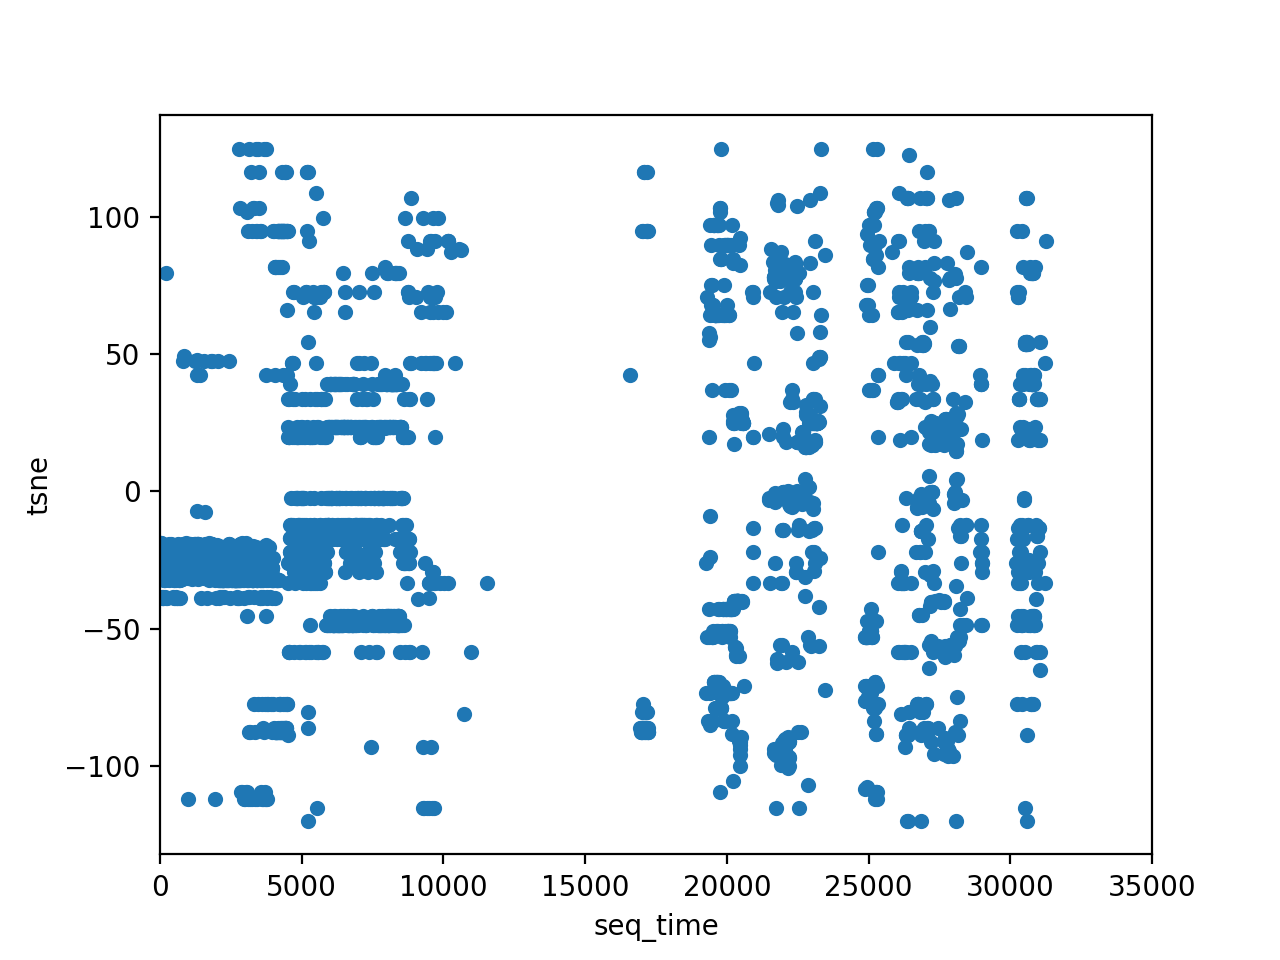

In [151]:
prueba.query('tag == {}'.format(BIRD)).plot(kind='scatter', x='seq_time', y='tsne', xlim=(0,35000))


#### deteccion automatica de cambios de comportamiento

In [35]:
import ruptures as rpt
## http://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/index.html


In [151]:
data_rpt = predictions_pd.query('day == "2018-01-24" and tag == 30 and recep_0 > 0')['recep_0'].to_numpy()

<IPython.core.display.Javascript object>


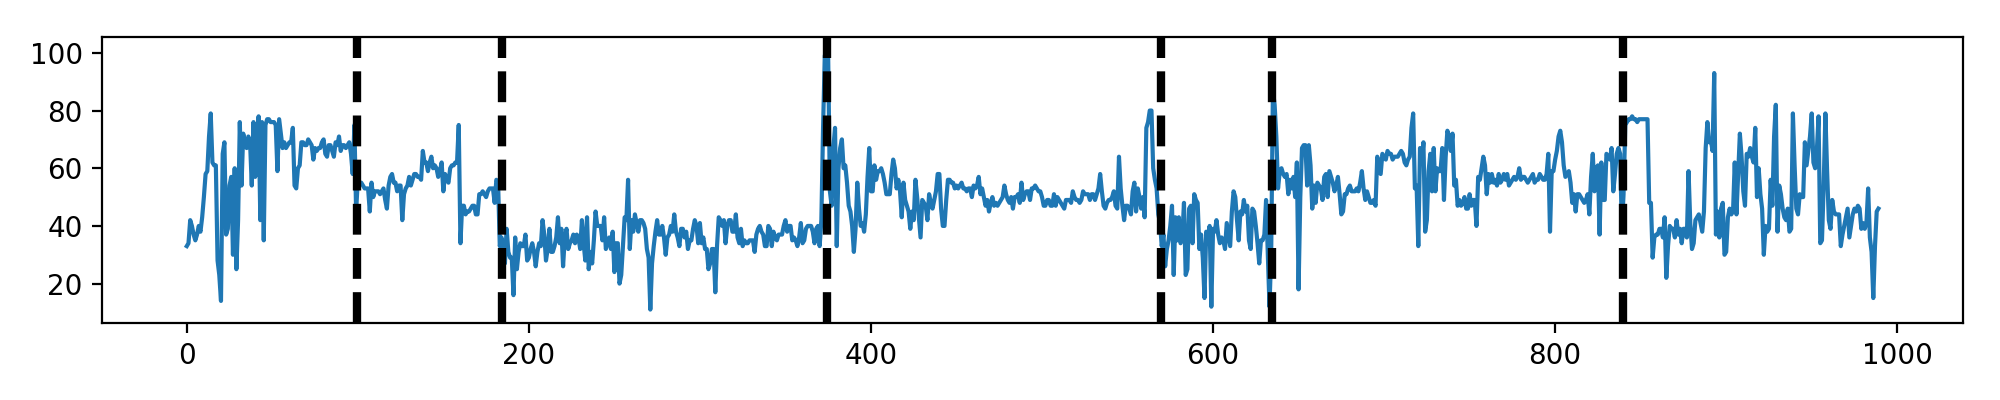

['00:01:40',
 '00:03:05',
 '00:06:15',
 '00:09:30',
 '00:10:35',
 '00:14:00',
 '00:16:30']

In [152]:

# model = 'rbf','l1','l2'
algo = rpt.Pelt(model="rbf", min_size=50).fit(data_rpt)
result = algo.predict(pen=10)

rpt.display(data_rpt, [], result)
plt.show()
[get_hour_from_seq_time(r) for r in result]

<IPython.core.display.Javascript object>


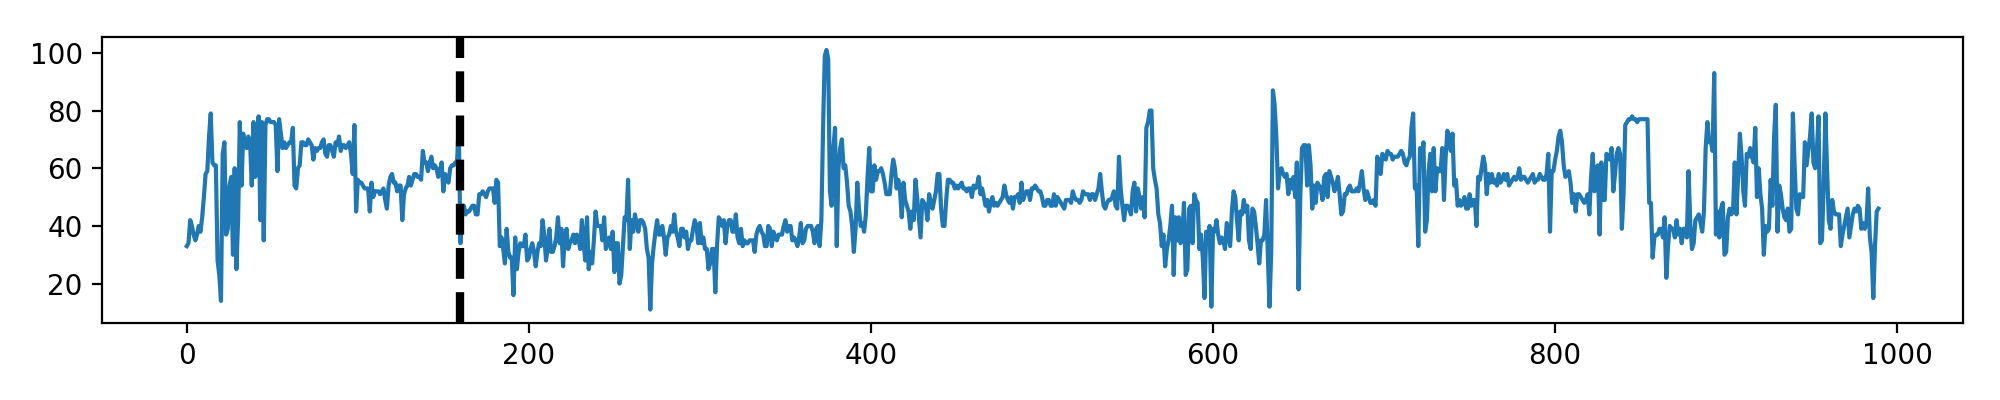

['00:02:40', '00:16:30']

In [153]:
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model).fit(data_rpt)
result = algo.predict(n_bkps=1)
#result = algo.predict(epsilon=0.6)

# show results
rpt.display(data_rpt, [], result)
plt.show()
[get_hour_from_seq_time(r) for r in result]

<IPython.core.display.Javascript object>


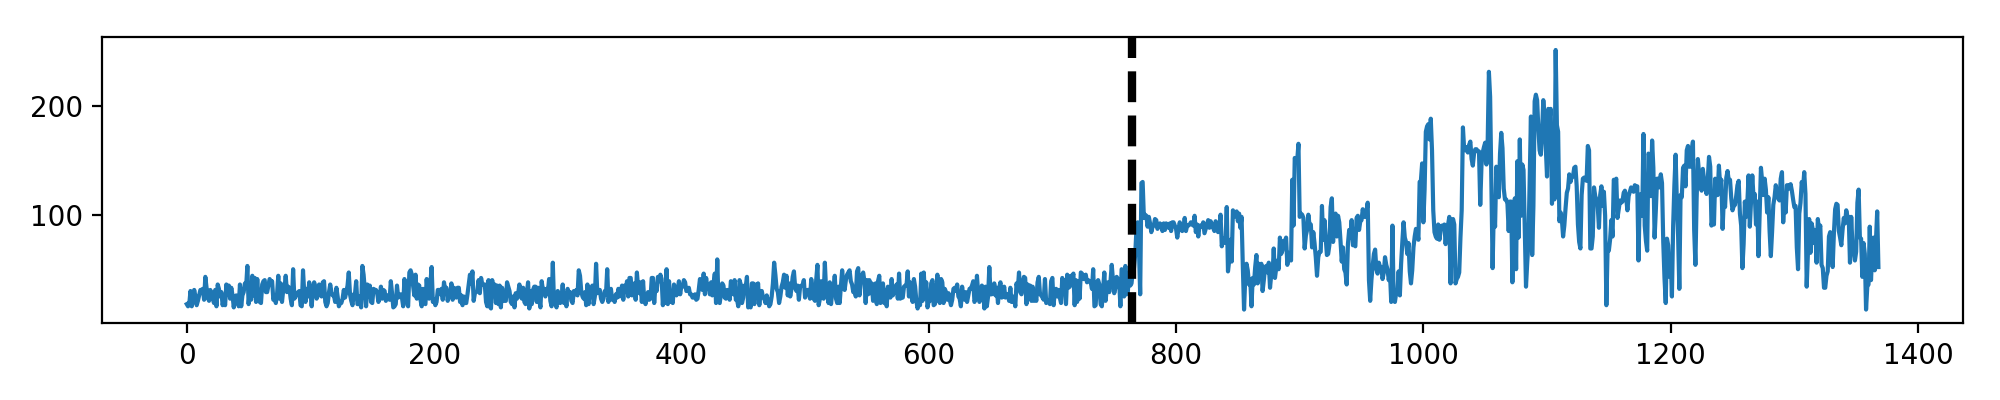

['00:12:45', '00:22:49']

In [60]:
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.BottomUp(model=model).fit(data_rpt)
result = algo.predict(n_bkps=1)
#result = algo.predict(epsilon=0.6)

# show results
rpt.display(data_rpt, [], result)
plt.show()
[get_hour_from_seq_time(r) for r in result]

<IPython.core.display.Javascript object>


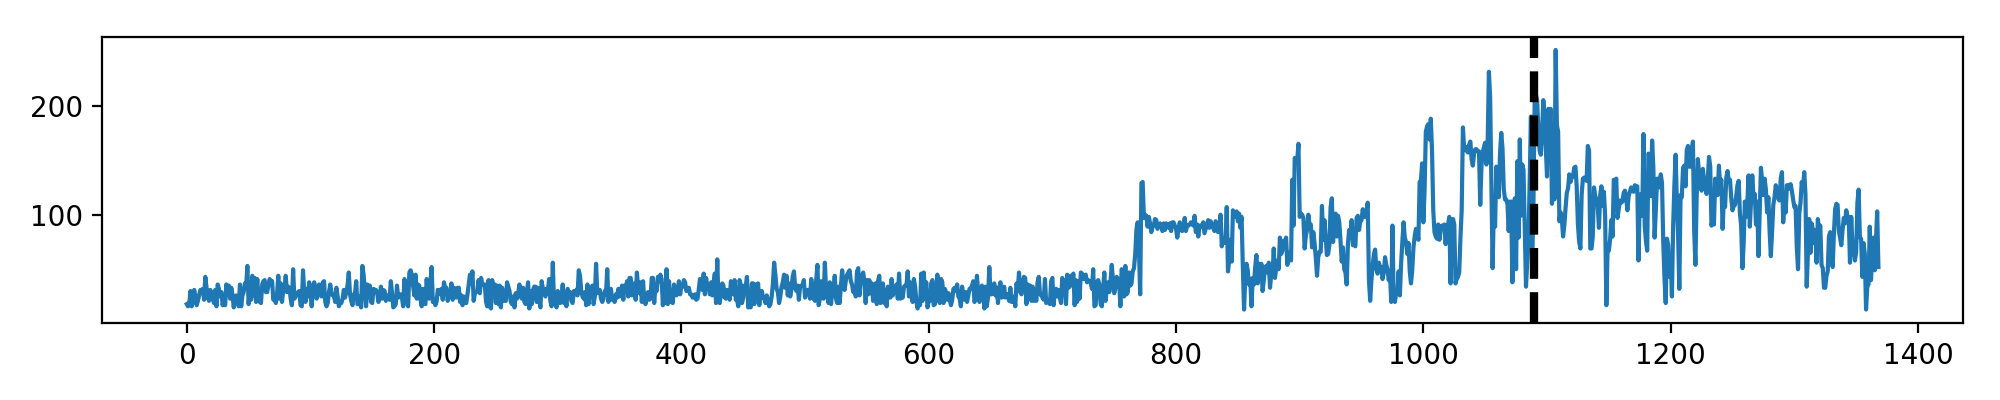

['00:18:10', '00:22:49']

In [61]:
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=40, model=model).fit(data_rpt)
result = algo.predict(n_bkps=1)
#result = algo.predict(epsilon=0.6)

# show results
rpt.display(data_rpt, [], result)
plt.show()
[get_hour_from_seq_time(r) for r in result]

### prueba usando 0s en la data

In [154]:
aux_pd = predictions_pd.query('day == "2018-01-24" and tag == 30')

In [155]:
seq_time_list = aux_pd['seq_time'].to_list()
recep_list = aux_pd['recep_0'].to_list()


In [156]:
data_rpt = []
seq_time_index = 0

for sec in range(0, 32400):
    if seq_time_index == len(seq_time_list):
        data_rpt.append(0)
        continue
    if abs(seq_time_list[seq_time_index] - sec) < 5:
        #print('yes')
        #break
        data_rpt.append(recep_list[seq_time_index])
        seq_time_index += 1
    else:
        data_rpt.append(0)

In [157]:
data_rpt = np.array(data_rpt)

<IPython.core.display.Javascript object>


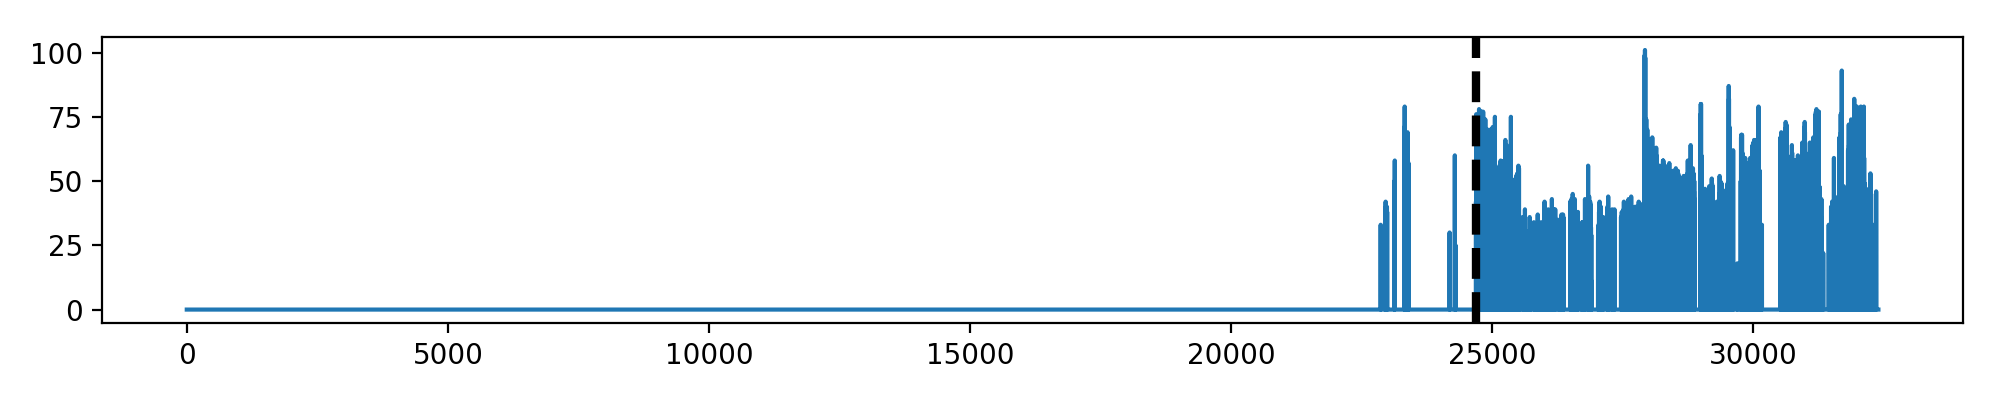

['06:51:30', '09:00:00']

In [158]:
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model).fit(data_rpt)
result = algo.predict(n_bkps=1)
#result = algo.predict(epsilon=0.6)

# show results
rpt.display(data_rpt, [], result)
plt.show()
[get_hour_from_seq_time(r) for r in result]

### funcion para devolver hora de salida

In [183]:
aux_pd = predictions_pd.query('day == "2018-01-11" and tag == 20')

In [168]:
def get_exit_roost_time(bird_data):
    ### usando solo emisiones >0
    res = {}
    for i in range(4):
        try:
            data = bird_data.query('recep_{} > 0'.format(i))
            if len(data) < 10:
                res['antenna_{}'.format(i)] = 'undefined'
                continue
            data_rpt = data['recep_{}'.format(i)].to_numpy()
            

            model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
            algo = rpt.Binseg(model=model).fit(data_rpt)
            result = algo.predict(n_bkps=1)
            exit_roost_index = result[0]
        except Exception as e:
            print(e)
            res['antenna_{}'.format(i)] = 'undefined'
            continue
        res['antenna_{}'.format(i)] = data.iloc[exit_roost_index]['time']
    return res


def get_exit_roost_time_v2(bird_data):
    ### usando emisiones >= 0
    res = {}
    for i in range(4):
        try:

            seq_time_list = bird_data['seq_time'].to_list()
            recep_list = bird_data['recep_{}'.format(i)].to_list()

            data_rpt = []
            seq_time_index = 0

            for sec in range(0, 32400):
                if seq_time_index == len(seq_time_list):
                    data_rpt.append(0)
                    continue
                if abs(seq_time_list[seq_time_index] - sec) < 5:
                    data_rpt.append(recep_list[seq_time_index])
                    seq_time_index += 1
                else:
                    data_rpt.append(0)
                    
            data_rpt = np.array(data_rpt)

            model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
            algo = rpt.Binseg(model=model).fit(data_rpt)
            result = algo.predict(n_bkps=1)
            exit_roost_index = result[0]
        except Exception as e:
            print(e)
            res['antenna_{}'.format(i)] = 'undefined'
            continue
        res['antenna_{}'.format(i)] = get_hour_from_seq_time(exit_roost_index)
    return res

##### tsne 

In [193]:
def get_exit_roost_time_v3(bird_data):    
    ### usando solo emisiones >0 + tsne
    try:
        data_rpt = TSNE(n_components=1).fit_transform(bird_data[['recep_0', 'recep_1', 'recep_2', 'recep_3']])
        if len(data_rpt) < 10:
            return 'undefined'
        #data_rpt = data.to_numpy()


        model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
        algo = rpt.Binseg(model=model).fit(data_rpt)
        result = algo.predict(n_bkps=1)
        exit_roost_index = result[0]
    except Exception as e:
        print(e)
        return 'undefined'
    return bird_data.iloc[exit_roost_index]['time']




def get_exit_roost_time_v4(bird_data):
    ### usando emisiones >= 0 + tsne
    ## TODO: implement

In [184]:
get_exit_roost_time(aux_pd)

{'antenna_0': '2018-01-11 01:35:46',
 'antenna_1': '2018-01-11 05:57:27',
 'antenna_2': '2018-01-11 07:08:32',
 'antenna_3': '2018-01-11 05:31:08'}

In [185]:
get_exit_roost_time_v2(aux_pd)

{'antenna_0': '05:36:05',
 'antenna_1': '08:38:50',
 'antenna_2': '03:08:00',
 'antenna_3': '06:08:35'}

In [194]:
get_exit_roost_time_v3(aux_pd)

'2018-01-11 03:04:38'

In [205]:
birds_exit_time = predictions_pd.groupby(['day', 'tag']).apply(get_exit_roost_time_v2)

In [206]:
birds_exit_time_pd = pd.DataFrame(birds_exit_time.apply(lambda x: min(x.values())))

In [207]:
birds_exit_time_pd_v2 = birds_exit_time_pd.copy()

In [199]:
#birds_exit_time_pd_v3 = birds_exit_time_pd.copy()

In [195]:
#birds_exit_time_pd_v0 = birds_exit_time_pd.copy()

In [212]:
birds_exit_time_pd_v0.join(birds_exit_time_pd_v2, rsuffix='_v1').join(birds_exit_time_pd_v3, rsuffix='_v2').to_csv('exit_roost_times.csv')


In [227]:
all_methods_res = pd.read_csv('exit_roost_times.csv').set_index(['day', 'tag'])
all_methods_res.head()

0      0_v1                  0.1
day        tag                                                    
2018-01-10 10   2018-01-10 06:01:51  05:39:50  2018-01-10 05:47:42
           11   2018-01-10 05:48:05  05:39:50  2018-01-10 05:47:31
           14   2018-01-10 08:18:07  07:44:05  2018-01-10 08:18:07
           15             undefined  06:12:55            undefined
           16             undefined  04:38:05            undefined

In [239]:
birds_roost_exit = all_methods_res[['0']]

In [236]:
days = list(all_methods_res.groupby('day').size().keys())

In [263]:
matrix_res = []
for i in range(len(MALES)):
    l = []
    for j in range(len(FEMALES)):
        l.append([])
    matrix_res.append(l)
    
for d in days:
    for i in range(len(MALES)):
        for j in range(len(FEMALES)):
            male = MALES[i]
            female = FEMALES[j]
            exit_time = birds_roost_exit.query('day == "{}" and (tag == {} or tag == {})'.format(d, male, female))['0']
            if len(exit_time) < 2 or exit_time[0] == 'undefined' or exit_time[1] == 'undefined':
                continue

            diff = (datetime.strptime(exit_time[0], '%Y-%m-%d %H:%M:%S')-datetime.strptime(exit_time[1], '%Y-%m-%d %H:%M:%S')).total_seconds()
            matrix_res[i][j].append(abs(diff))

In [270]:
matrix_res[MALES.index(31)][FEMALES.index(30)]

[1075.0, 2613.0, 1341.0, 420.0, 2635.0, 876.0, 86.0, 2682.0, 7385.0]

In [289]:
mean_matrix_res = np.zeros((len(FEMALES), len(MALES)))
for i in range(len(MALES)):
    for j in range(len(FEMALES)):
        #mean_matrix_res[j][i] = np.median(matrix_res[i][j])
        #mean_matrix_res[j][i] = np.mean(matrix_res[i][j])
        mean_matrix_res[j][i] = len([e for e in matrix_res[i][j] if e <= 40*60])

<IPython.core.display.Javascript object>


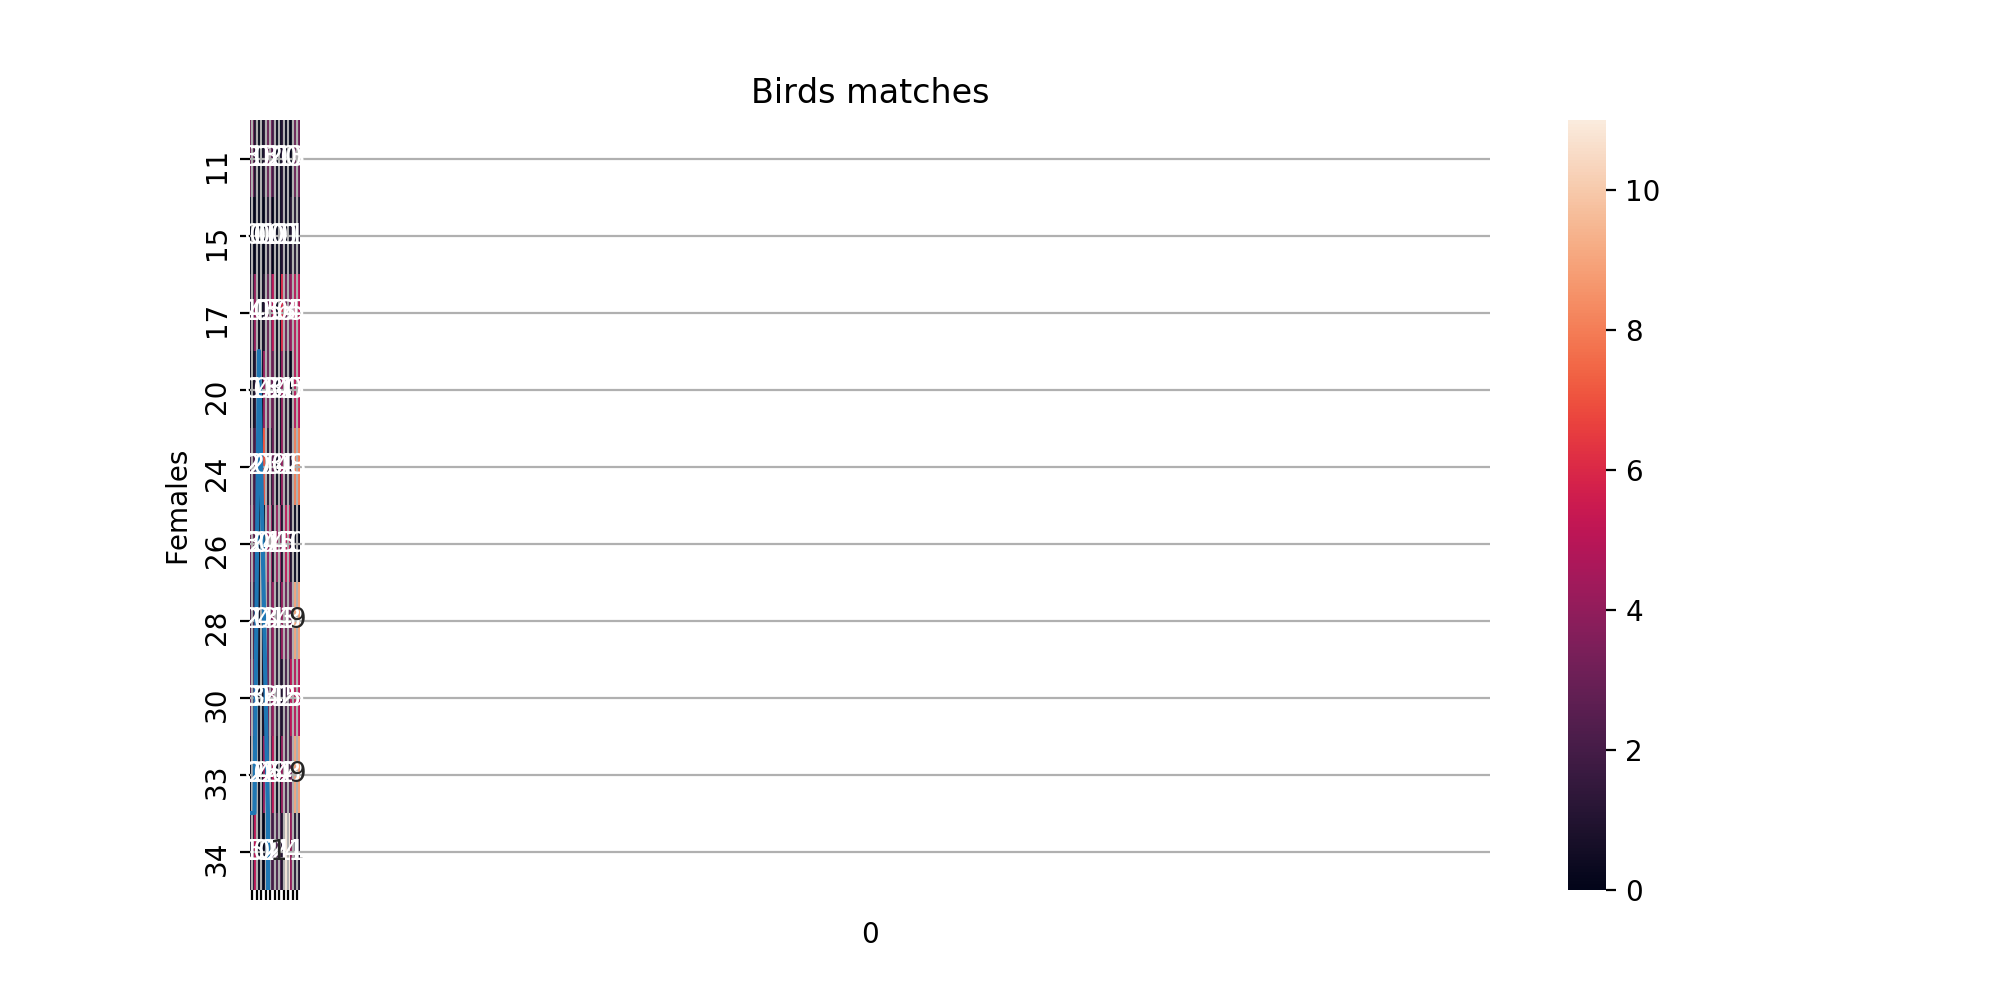

[Text(95.7222,0.5,'Females'), Text(0.5,25.7222,'Males')]

In [290]:
plt.figure(figsize=(10,5))
    
plt.title('Birds matches')
matrix_res_pd = pd.DataFrame(mean_matrix_res)
matrix_res_pd.columns = MALES
matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g', xticklabels=True, yticklabels=True, vmin=0)
ax.set(xlabel='Males', ylabel='Females')

##### horarios de las hembras vs los machos

In [304]:
females_times = birds_roost_exit.reset_index().query('tag in {}'.format(FEMALES))["0"].str.split(' ').str[1].str.split(':').str[0]
males_times = birds_roost_exit.reset_index().query('tag in {}'.format(MALES))["0"].str.split(' ').str[1].str.split(':').str[0]


In [312]:
print("females times", pd.DataFrame(females_times).groupby("0").size())
print("males times", pd.DataFrame(males_times).groupby("0").size())

females times 0
00     9
01     9
02     3
03     6
04     9
05    36
06    21
07    11
08    14
dtype: int64
males times 0
00     4
01    10
02     8
03     4
04     6
05    34
06    37
07    12
08    15
dtype: int64


In [313]:
pd.DataFrame(females_times).groupby("0").size()

0
00     9
01     9
02     3
03     6
04     9
05    36
06    21
07    11
08    14
dtype: int64

False

In [352]:
def get_secondos_of_day(hour):
    if isinstance(hour,float) and np.isnan(hour):
        return None
    return (datetime.strptime(hour, '%H:%M:%S')-datetime.strptime('00:00:00', '%H:%M:%S')).total_seconds()



In [392]:
female_aux = birds_roost_exit.copy().reset_index().query('tag in {}'.format(FEMALES))["0"].str.split(' ').str[1].apply(get_secondos_of_day)
male_aux = birds_roost_exit.reset_index().query('tag in {}'.format(MALES))["0"].str.split(' ').str[1].apply(get_secondos_of_day)


In [393]:
female_aux_pd = pd.DataFrame(female_aux).reset_index(drop=True)
male_aux_pd = pd.DataFrame(male_aux).reset_index(drop=True)

In [ ]:
female_aux_pd.columns = ['hour']
female_aux_pd['one'] = 1
male_aux_pd.columns = ['hour']
male_aux_pd['one'] = 1

In [397]:
#male_aux_pd.join(female_aux_pd, lsuffix='_male', rsuffix='_female')

<IPython.core.display.Javascript object>


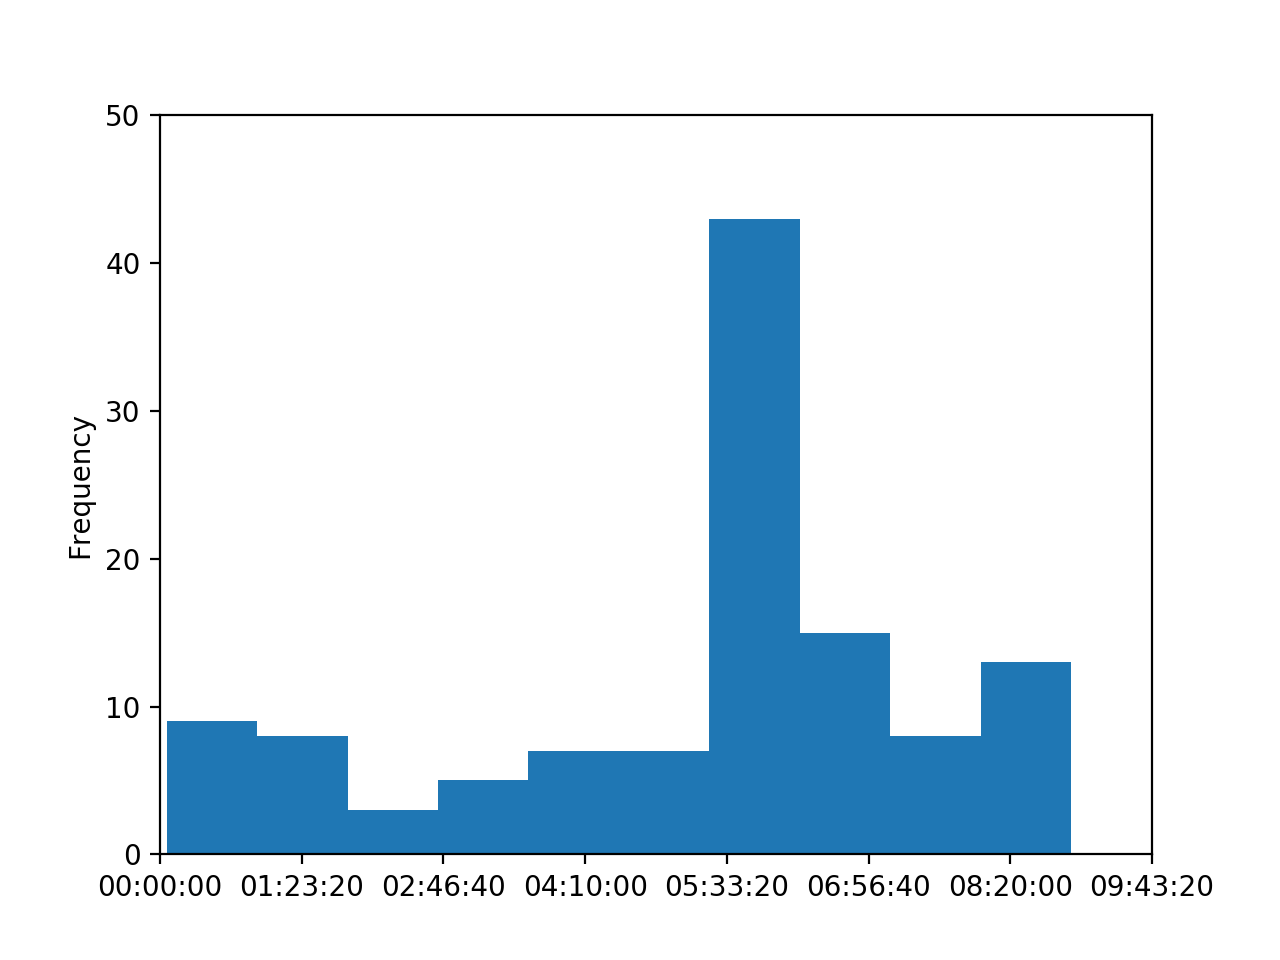

[Text(0,0,'00:00:00'),
 Text(0,0,'01:23:20'),
 Text(0,0,'02:46:40'),
 Text(0,0,'04:10:00'),
 Text(0,0,'05:33:20'),
 Text(0,0,'06:56:40'),
 Text(0,0,'08:20:00'),
 Text(0,0,'09:43:20')]

In [415]:
ax = female_aux_pd[female_aux_pd.hour.notna()].hour.plot.hist(xlim=(0,35000), ylim=(0,50))
ax.set_xticklabels([get_hour_from_seq_time(tick) for tick in ax.get_xticks().astype(int)])

<IPython.core.display.Javascript object>


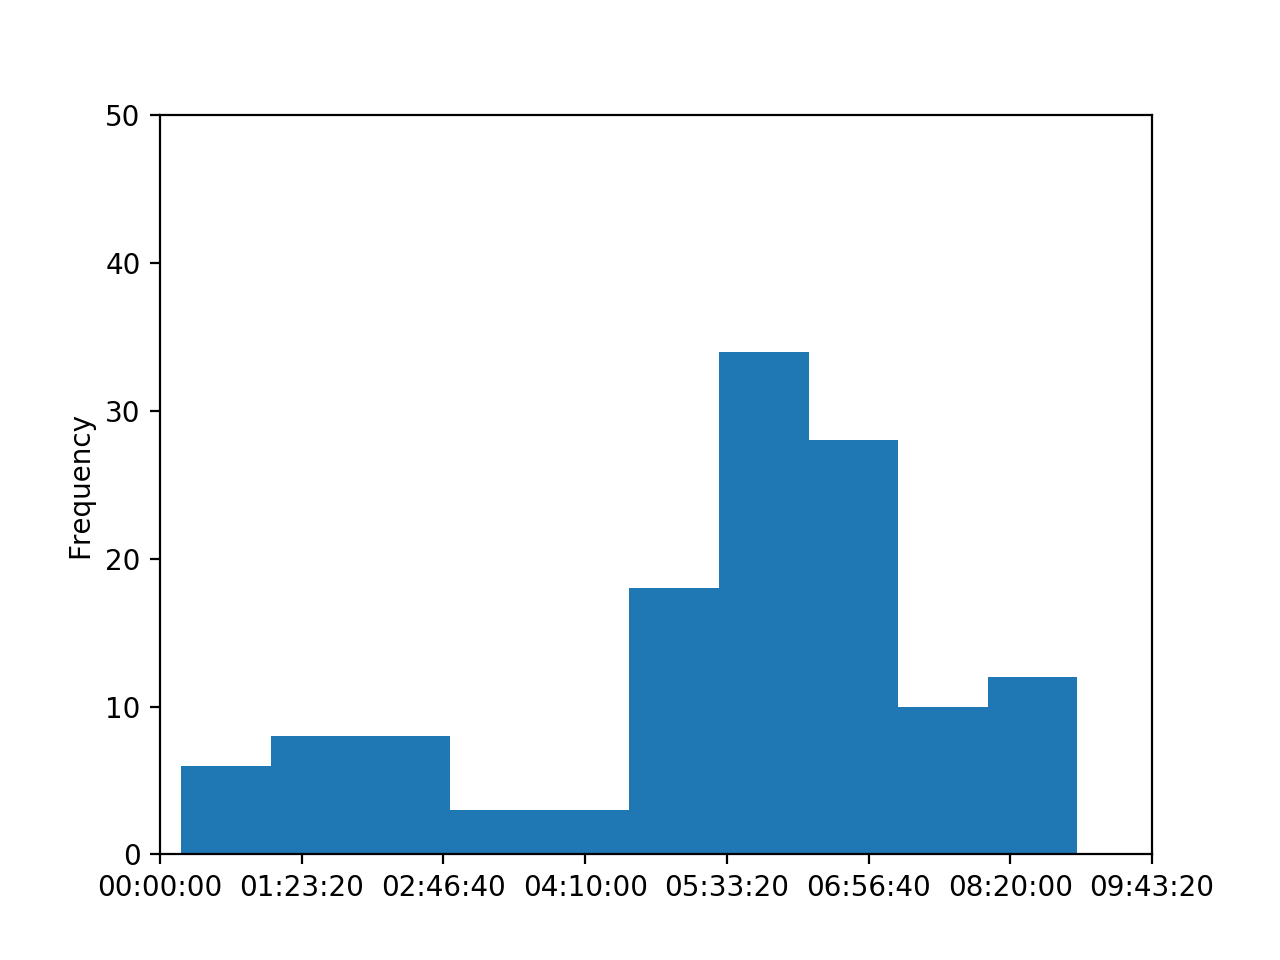

[Text(0,0,'00:00:00'),
 Text(0,0,'01:23:20'),
 Text(0,0,'02:46:40'),
 Text(0,0,'04:10:00'),
 Text(0,0,'05:33:20'),
 Text(0,0,'06:56:40'),
 Text(0,0,'08:20:00'),
 Text(0,0,'09:43:20')]

In [416]:
ax = male_aux_pd[male_aux_pd.hour.notna()].hour.plot.hist(xlim=(0,35000), ylim=(0,50))
ax.set_xticklabels([get_hour_from_seq_time(tick) for tick in ax.get_xticks().astype(int)])